<a href="https://colab.research.google.com/github/rigonzal/ML-2019-1/blob/master/Tarea2/Pregunta%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-393: Máquinas de Aprendizaje

## Tarea 2 - Pregunta 1

16-08-2019



*   Rodrigo González Smith           -- 201303026-2
*   Ignacio Valenzuela Albornoz   -- 201473055-1


In [0]:
import sys, os, re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Introducción

La mayoría de las veces cuando enfrentamos un problema de clasificación, nos emerge de las entrañas la necesidad de buscar un hiperplano que logre separar lo mejor posible una cierta cantidad de categorías y así poder clasificar nuevos datos de forma más precisa. Existen muchos métodos para la creación de este hiperplano, pero solo uno obtendrá una mejor aproximación y dependerá del espacio del problema que queremos abordar, como por ejemplo, que los datos presentes no sean linealmente separables.

Para analizar este caso en particular, crearemos datos que no sean linealmente separables. Se crea una función *do_circles* el cual nos devolverá dos tipos de datos, los etiquetados con 0 (que van siguiendo a la circunferencia pero no están en ella) y 1 (los puntos que se encuentran dentro de la circunferencia). 


## a) Creando los datos

Para especificar como se ejecuta esta función, se explicarán ciertas variables:


*   n_dots: Variable que indica la cantidad de puntos que se quiere generar en la muestra, con un valor default de 3000
*   dev: La desviación estándar de la distribución normal que se utilizará. Esto es principalmente para definir que tan alejada de la media estarán los valores, por lo que mientras más sea su valor, más ruido agregará a la muestra de datos.
*   scr: Es un parámetro que representará un porcentaje. Como queremos asegurarnos que ciertos puntos estén dentro de la circunferencia, se multiplicara los valores de los puntos por este porcentaje reduciendo así su magnitud. El valor por defecto es 0.3, por lo que reducir el valor a un 30% del total asegurará que esos puntos estén en el centro y no cerca del borde.
*   radius: El radio de la circunferencia donde generaremos los puntos, el que será usado en el linspace de numpy para generar los puntos dentro de ella.



In [0]:
def do_circles(n_dots = 3000, dev = 0.15, scr = 0.3, radius = 1):
    generator = check_random_state(42)
    
    linspace = np.linspace(0, 2 * radius * np.pi, n_dots)
    circle_x = np.cos(linspace)
    circle_y = np.sin(linspace)

    inner_circle_x, outer_circle_x, inner_circle_y, outer_circle_y = train_test_split(circle_x, circle_y, test_size = 0.5)
    inner_circle_x , inner_circle_y = inner_circle_x*scr , inner_circle_y*scr 

    X = np.vstack((
        np.append(outer_circle_x, inner_circle_x),
        np.append(outer_circle_y, inner_circle_y)
    )).T

    y = np.hstack([
        np.zeros(n_dots // 2, dtype=np.intp),
        np.ones(n_dots // 2, dtype=np.intp)
    ])

    X += generator.normal(scale = dev, size = X.shape)
    return train_test_split(X, y, test_size=0.3, random_state=42)

Analizando la función de arriba, podemos ver los siguientes pasos:


*   Se crea un generador con una semilla número 42. Esta función genera una instancia RandomState de numpy con ese número de semilla
*   Queremos tomar la mayoría del espectro de una circunferencia, por lo que se crea un array con valores desde 0 hasta 2\*pi\*r, es decir, el perímetro de la circunferencia. Al tener una gran cantidad de puntos, podemos albergar una gran cantidad de valores.
*   Luego se crearán dos circunferencias usando como valores el array anteriormente mencionado. Una creada con la función coseno y otra con la función seno.  Esto dará pie a dos circunferencias que tienen un área de intersección en el cuarto cuadrante de sin(theta) y el segundo cuadrante de cos(theta).  Luego, gracias a la función train_test_split, podemos separarlos en secciones internas y externas.
* Para hacer la diferencia entre circulo interno y externo, al interno debemos reducirle su magnitud para que no supere el 30%, es decir, máximo de 0,3.



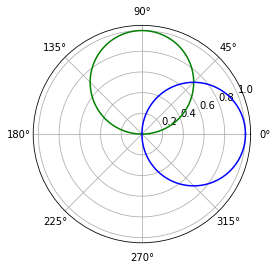

In [100]:
linspace = np.linspace(0, 2 * np.pi, 3000)
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection = 'polar')
r = linspace
ax.plot(linspace, np.abs(np.sin(linspace))*(r<np.pi) , 'g')
ax.plot(linspace, np.abs(np.cos(linspace))*(r>3*np.pi/2) + np.abs(np.cos(linspace))*(r<np.pi/2), 'b')
plt.show()

## b) Graficando los datos

Construimos una función que pueda graficar los puntos generados. Se hace ocupando la librería de matplotlib agregando dos subfiguras, donde una presenta los puntos siguiendo la circunferencia y otros dentro de ella. En primera instancia graficaremos los datos de prueba, quedando lo siguiente.

In [0]:
  def plot_circles(X_train, y_train):
    fig = plt.figure()
    fig1 = fig.add_subplot(121)
    fig1.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], color = 'g')
    fig2 = fig.add_subplot(122)
    fig2.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], color = 'r')
    fig1.set_title("Train Set")


In [0]:
x_train, x_test, y_train, y_test = do_circles(3000, 0.15, 0.3, 1)

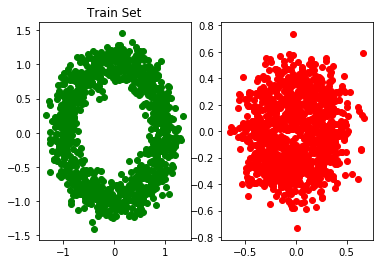

In [103]:
plot_circles(x_train, y_train)

Podemos apreciar que los puntos verdes buscan formar una cirunferencia con un borde bastante ancho, mientras que los puntos rojos intentan rellenar el vacío que deja la circunferencia. Claramente, con la inclusión de la desviación estándar y el ruido asociado que genera, podemos apreciar que hay puntos de un gráfico que pueden pertenecer al otro sin problema.


## c) Regresión Logística

Ahora se realizará una regresión logística para comprobar como este modelo puede aseverar la etiqueta correcta a los puntos analizando solo su valor de radián.  Primero, para comparar, ocuparemos dos sets generados de datos que poseerán los mismos parámetros a diferencia de uno que es la desviación estándar. El primero tendrá un valor de 0.2 para ver el comportamiento con un error asociado en la muestra, mientras que otro con valor 0, reduciendo así el error y comparando así como este afecta en el aprendizaje.

In [0]:
x_train1, x_test1, y_train1, y_test1 = do_circles(5000, 0.2, 0.3, 1)
x_train2, x_test2, y_train2, y_test2 = do_circles(5000, 0, 0.3, 1)

Procederemos a plotear estos dos sets para anticipar el desempeño del modelo.

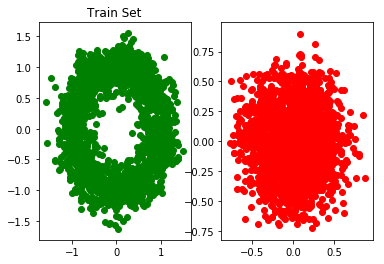

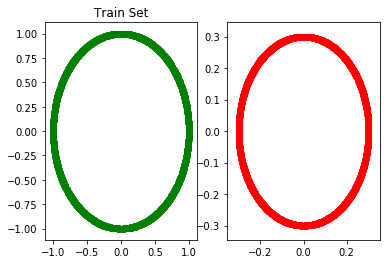

In [105]:
plot_circles(x_train1, y_train1)  #Gráfico con mas error
plot_circles(x_train2, y_train2)  #Gráfico sin error

Al analizar ambos, podemos apreciar que el primero posee un error más pronunciado (incluso más que el primer intento, que poseía una desviación de 0.15), mientras que el segundo a no poseer una desviación estándar, poseemos un ploteo sin errores. Pareciese ser que en los gráficos sin errores son el mismo círculo pero con distinto color, pero se debe apreciar los valores de los ejes para ver que el círculo rojo es más pequeño, por lo tanto, está dentro del círculo.

Ahora procederemos a entrenar un modelo de regresión logística para ver su desempeño en ambos set de datos. Comenzamos con el conjunto que posee error.

In [10]:
log_reg = LogisticRegression()  #Modelo que presenta error
log_reg.fit(x_train1, y_train1)
log_reg.score(x_test1, y_test1) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6386666666666667

In [11]:
log_reg1 = LogisticRegression() #Modelo que no presenta error
log_reg1.fit(x_train2, y_train2)
log_reg1.score(x_test2, y_test2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.56

Primero que todo, el desempeño en ambos sets puede ser parecido. Al generar diversos datasets con la función podemos encontrar mejores desempeños del modelo con error o sin error. Lo que podría parecer extraño es que esto sea así, ya que el dataset sin error las clases están separadas completamente, por lo que el modelo debiese de obtener un desempeño casi cercano a 1. 

El problema se genera principalmente en el problema el cual se enfrenta. En este caso la regresión logística busca clasificar los datos analizando la magnitud de los datos que recibe para entrenar utilizando la técnica de máxima verosimilitud. Por lo tanto, logra buscar la probabilidad, considerando los datos, que este punto se encuentre fuera o dentro del círculo. El problema es que este algoritmo es considerado lineal, ya que como cualquier regresión, busca una relación lineal entre sus variables. 

Con lo anterior, el modelo buscara encontrar relaciones lineales entre sus datos pero no le será fácil, debido a que los puntos no siguen esa relación. Los puntos que están fuera de la circunferencia serán los que posean un valor (x,y) muy pequeño o muy grande para ambos, o también con un x muy grande con y pequeño, y así. 


## d) Graficar modelos

Ahora se utilizará una función la cual graficaremos los datos que se generaron y también el umbral de decisión que fue generado por la regresión lineal.

In [0]:
def plot_classifier(clf, X_train, Y_train, X_test, Y_test, labels, tr_tst='test', show= False):
    plt.figure(figsize=(12, 8))
    axis = plt.axes()
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j] # grid for cassifier
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()]) # what the classifier predicts over the space
    Z = Z.reshape(XX.shape) # for consistency
    Zplot = Z > 0.5 # to separate both classes
    axis.pcolormesh(XX, YY, Zplot, cmap='YlGn')
    axis.contour(XX, YY, Zplot, alpha=1, colors=["b"], linestyles=["-"], levels=[0.5])
    if show == True:
      if tr_tst == 'train':
        axis.scatter(X_train[Y_train==0][:,0], X_train[Y_train==0][:,1], color = 'r')
        axis.scatter(X_train[Y_train==1][:,0], X_train[Y_train==1][:,1], color = 'y')
      elif tr_tst == 'test':
        axis.scatter(X_test[Y_test==0][:,0], X_test[Y_test==0][:,1], color = 'r')
        axis.scatter(X_test[Y_test==1][:,0], X_test[Y_test==1][:,1], color = 'y')
    if labels:
      plt.xlim(labels[0])
      plt.ylim(labels[1])
    plt.show()
    plt.close()

Generaremos los gráficos para ambos datasets, considerando tanto datos de entrenamiento como de pruebas.

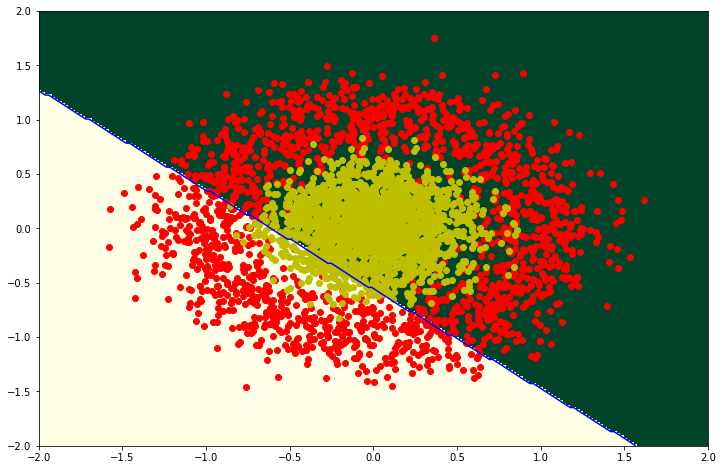

In [13]:
plot_classifier(log_reg, x_train1, y_train1, x_test1, y_test1, 'train', True) # Datos de entrenamiento con error

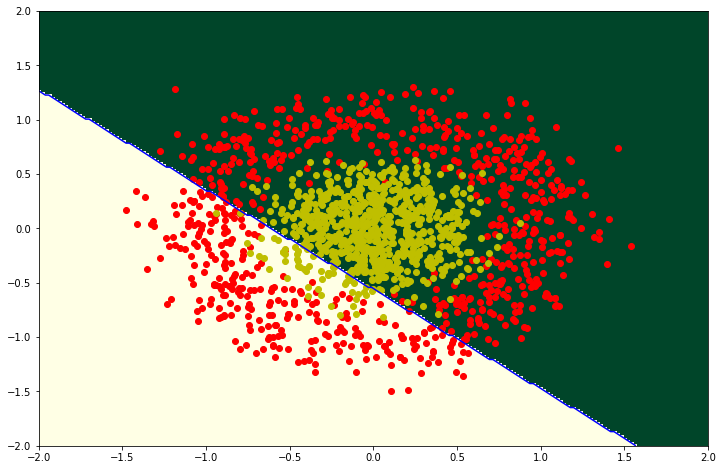

In [14]:
plot_classifier(log_reg, x_train1, y_train1, x_test1, y_test1, 'test', True) # Datos de prueba con error

Se puede apreciar que la regresión logística busco una función que permitiera dividir las clases en dos secciones, claramente una tarea imposible.  Los puntos rojos son los que estan etiquetados fuera de la circunferencia, mientras que los amarillos son los etiquetados dentro de la circunferencia. La zona verde implica la zona en la cual los puntos se consideraran "dentro de circunferencia" y la blanca los "fuera de la circunferencia", y la línea de color negro es el umbral de decisión. Con esto podemos concluir que este modelo no es el adecuado para este problema, por lo que es menester analizar otras opciones.

## e) SVM

Otro modelo que se adaptará mejor a este problema es el SVM (Support Vector Machine). 

SVM tendrá como objetivo encontrar un hiperplano el cual pueda separar las clases. Considerando que son solo dos, buscará un plano. Para aplicarlo, ocuparemos la función SVC de la librería sklearn, ocupando dos parámetros muy importantes: C y gamma.

El parámetro C indicará que tan propenso será el algoritmo a admitir errores de clasificación durante el entrenamiento. Este parámetro, dentro del problema de optimización, sumará un cierto valor a la función objetivo, dificultando así la maximización del problema. Si se tiene C = 0, no habrá penalización por lo que podrán haber más errores de clasificación (ya que se basará en la cota de 1/||w||, haciendo el umbral de decisión más "suave"). En cambio, si es > 0, el modelo será más fino con estos errores de clasificación, adaptando el hiperplano a evitar aún más estos errores.

Por otra parte, el parámetro de gamma implica que tan fiel a los datos de entrenamiento será el hiperplano generado, es decir, en que magnitud se tenderá a generalizar el problema con el hiperplano creado. Con un valor menor de gamma, se tendrá un hiperplano más generalizado. En cambio, si gamma aumenta, el modelo buscará un hiperplano que se adapte aún más al dato de entrenamiento, teniendo un hiperplano muy certero, pero lo más probable que solo para ese conjunto de datos.

Par analizar la influencia de los valores de estos parámetros, creamos una función que genere modelos de SVM y los graficaremos para hacer la comparativa.

In [0]:
def generateSVM(x_train, y_train, x_test, y_test, which, show, C_arr, gamma_arr):
  best = -10
  pair = ''
  for gammas in gamma_arr:
    for cs in C_arr:
      SV = SVC(C=cs, gamma = gammas)
      SV.fit(x_train, y_train)
      score = SV.score(x_test, y_test)
      if score > best:
        best = score
        pair = (gammas, cs)
      print("Gamma: ", gammas, "| C: ", cs)
      plot_classifier(SV, x_train, y_train, x_test, y_test, which, show)
      plt.close()
  print("Best score: ", best, " with parameters C=", pair[1], " and gamma=", pair[0])

Gamma:  0.1 | C:  0.1


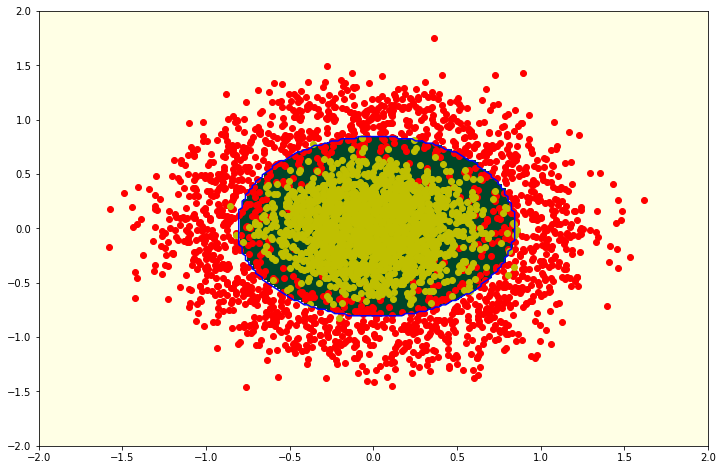

Gamma:  0.1 | C:  1


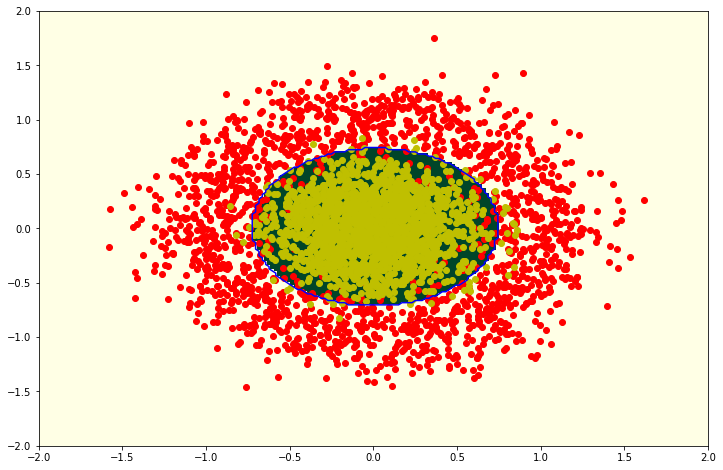

Gamma:  0.1 | C:  10


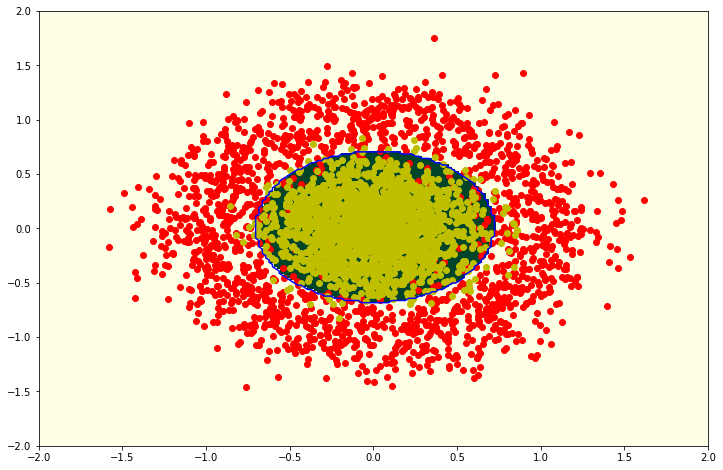

Gamma:  0.1 | C:  100


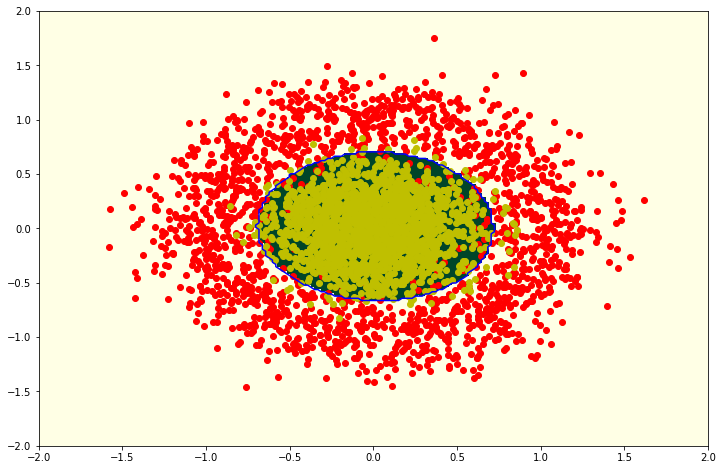

Gamma:  0.1 | C:  1000


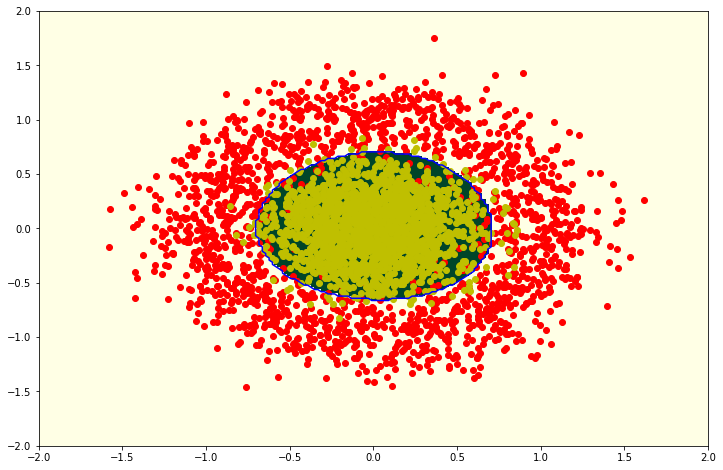

Best score:  0.962  with parameters C= 100  and gamma= 0.1


In [16]:
generateSVM(x_train1, y_train1, x_test1, y_test1, 'train', True, [0.1, 1, 10, 100, 1000], [0.1])

Al hacer cambios al parámetro C, vemos como desde el valor 0.1 a los más altos va considerando menos errores de clasificación, lo que implica que el umbral de decisión disminuya su radio. En el primer gráfico podemos apreciar que admite más puntos rojos dentro del umbral, mientras que aumenta el C no lo permite, reduciendo su radio y dejando esos puntos más afuera. Ahora analizaremos los valores modificando el gamma.

Gamma:  0.1 | C:  0.1


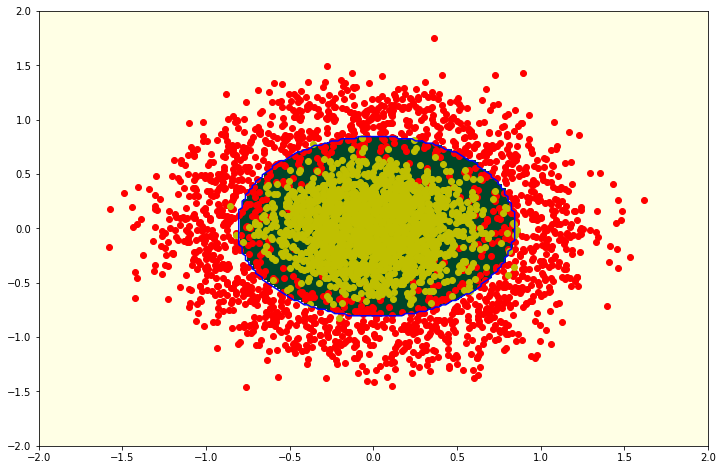

Gamma:  1 | C:  0.1


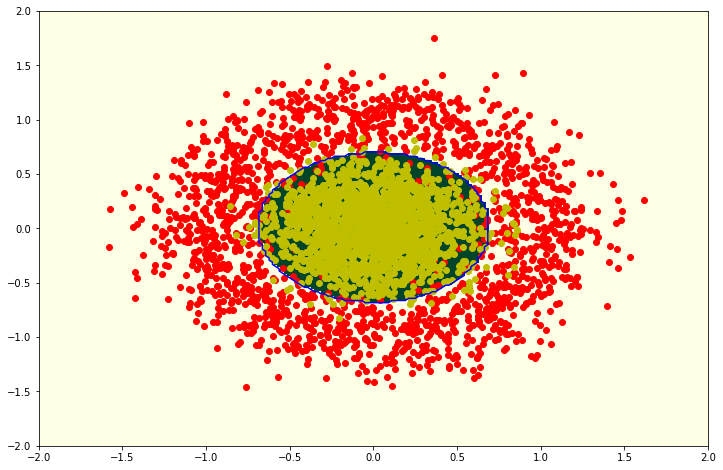

Gamma:  10 | C:  0.1


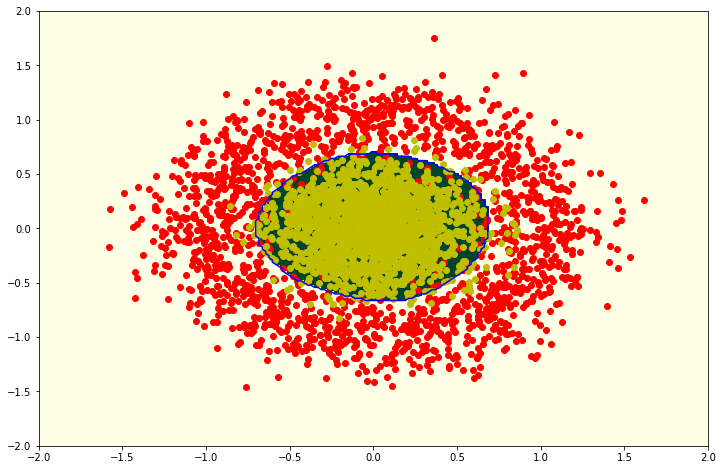

Gamma:  100 | C:  0.1


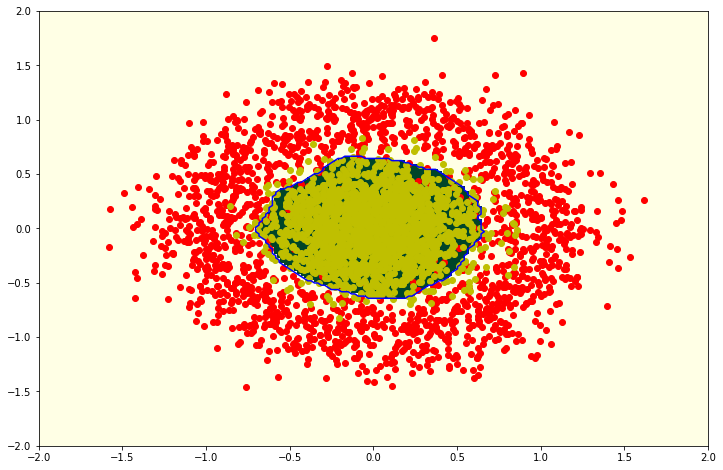

Gamma:  1000 | C:  0.1


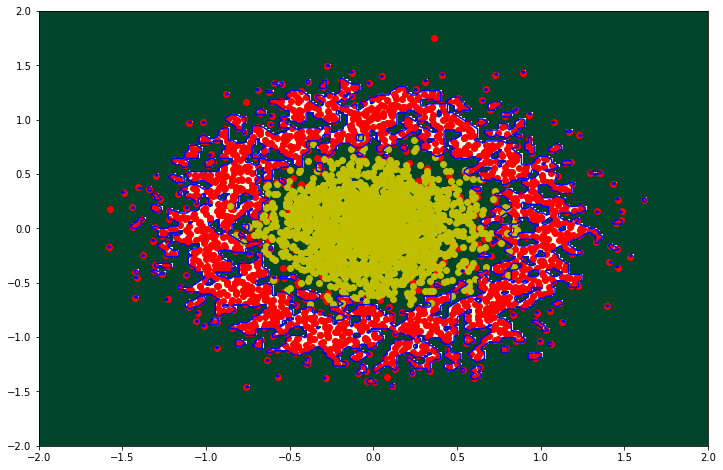

Best score:  0.964  with parameters C= 0.1  and gamma= 1


In [17]:
generateSVM(x_train1, y_train1, x_test1, y_test1, 'train', True, [0.1], [0.1, 1, 10, 100, 1000])

Podemos apreciar la aberración que va quedando a medida que el gamma sube, sobretodo con gamma= 1000. Se ve que intenta ajustarse lo más posible a los datos de entrenamiento, por lo que este parámetro es más sensible que C. Analizando cuales parámetros obtuvieron los mejores desempeños en conjunto de pruebas, variando C obtenemos que el par C = 100 y gamma = 0.1 posee 0,962, mientras que variando el gamma, los parámetros C = 0.1 y gamma = 1 obtienen un 0,964, haciendo este último el de mejor desempeño. 

En conclusión, podemos ver que estas variables influyen bastante en la frontera generada. Debido a que los datos con error son debido a una distribución normal, no es muy recomendable dar un mayor alto a gamma, debido a que perdera generalización del problema ya que buscará adaptarse lo mejor del conjunto de entrenamiento. Lo recomendable sería aumentar el valor de C ya que tomará más en cuenta los errores de clasificación y dejando una frontera suave, lo que podrá generalizar y obtener un buen desempeño en conjunto de pruebas al mismo tiempo.


## f) KNN

Ahora es el momento de analizar otro algoritmo llamado K-Nearest Neighbors.

In [0]:
KNN = KNeighborsClassifier(n_neighbors=5, p=2)

In [21]:
KNN.fit(x_train1, y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

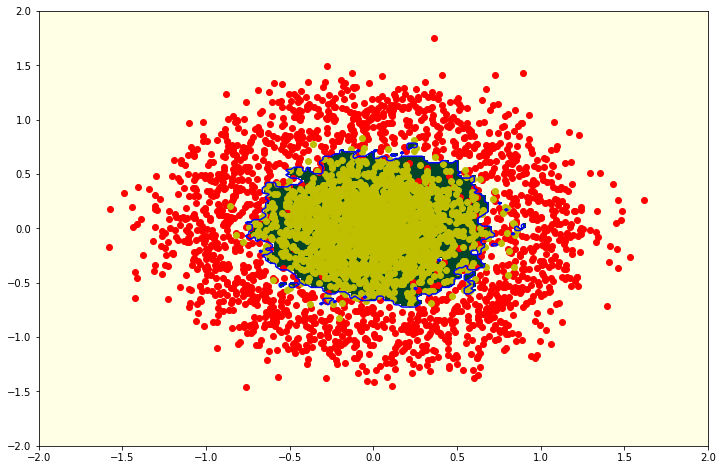

In [23]:
plot_classifier(KNN, x_train1, y_train1, x_test1, y_test1, 'train', True)

El uso de KNN implica una frontera de decisión mucho más adaptada al conjunto de entrenamiento, y es principalmente porque KNN utiliza los n vecinos de un punto particular para decidir su etiqueta. En el ejemplo anterior los parámetros seteados con n_neighbors = 5 y p = 2, el cual explicaremos su función después de realizar otra tarea.

Para comprobar bien la influencia de estos parámetros en el algoritmo, se realizará un cross validation para analizar que valores son los que entregan un mejor score.

In [0]:
neighbors_array = [1, 2, 3, 4, 5]
p_array = [1, 2, 3]
folds = KFold(10)
scores  = np.zeros([15,10])
MAE  = np.zeros([15,10])
indexes = []
N = 0
o = 0
for i in range(0,5):
  for h in range(0,3):
    j = 0
    for train_index, val_index in folds.split(x_train1):
      if N == 0:
        N = len(val_index)
      y_train_i = y_train1[train_index]
      x_train_fold = x_train1[train_index]
      y_val_i = y_train1[val_index]
      x_val_fold = x_train1[val_index]
      KNN = KNeighborsClassifier(n_neighbors= neighbors_array[i], p=p_array[h])
      model = KNN.fit(x_train_fold, y_train_i)
      scores[o][j] = model.score(x_val_fold,y_val_i)
      y_pred = model.predict(x_val_fold)
      MAE[i-1][j] = np.sum([abs(y_pred[k] - y_val_i[k]) for k in range(N-1) ])/N
      j+=1
      o+=1
      if o == 15:
        o = 0
      indexes.append((j, neighbors_array[i], p_array[h]))

In [48]:
i = 0
for element in indexes:
  print("K-fold: ", element[0])
  print("Neigbors: ", element[1])
  print("P-value: ", element[2])
  print("Scores: ", scores[i][element[0] - 1])
  i += 1
  if i == 15:
    i = 0

K-fold:  1
Neigbors:  1
P-value:  1
Scores:  0.9628571428571429
K-fold:  2
Neigbors:  1
P-value:  1
Scores:  0.9542857142857143
K-fold:  3
Neigbors:  1
P-value:  1
Scores:  0.9485714285714286
K-fold:  4
Neigbors:  1
P-value:  1
Scores:  0.96
K-fold:  5
Neigbors:  1
P-value:  1
Scores:  0.9171428571428571
K-fold:  6
Neigbors:  1
P-value:  1
Scores:  0.9628571428571429
K-fold:  7
Neigbors:  1
P-value:  1
Scores:  0.9628571428571429
K-fold:  8
Neigbors:  1
P-value:  1
Scores:  0.9485714285714286
K-fold:  9
Neigbors:  1
P-value:  1
Scores:  0.9371428571428572
K-fold:  10
Neigbors:  1
P-value:  1
Scores:  0.9571428571428572
K-fold:  1
Neigbors:  1
P-value:  2
Scores:  0.9628571428571429
K-fold:  2
Neigbors:  1
P-value:  2
Scores:  0.9571428571428572
K-fold:  3
Neigbors:  1
P-value:  2
Scores:  0.9457142857142857
K-fold:  4
Neigbors:  1
P-value:  2
Scores:  0.9571428571428572
K-fold:  5
Neigbors:  1
P-value:  2
Scores:  0.9228571428571428
K-fold:  6
Neigbors:  1
P-value:  2
Scores:  0.957142

En este proceso se puede apreciar los desempeños de los diversos parámetros. No se pueden ver diferencias tan grandes en el desempeño, pero podemos utilizar otra función llamada GridSearchCV para que haga un crossvalidation con todos los distintos parámetros que deseemos. Con esta función además, después de entrenar, podemos obtener los parámetros con los mejores valores.

In [0]:
grid_param = {"n_neighbors": [1,2,3,4,5],
              "p": [1,2,3]}
gd_sr = GridSearchCV(estimator=KNeighborsClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)

In [50]:
gd_sr.fit(x_train1, y_train1)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5], 'p': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [51]:
best_parameters = gd_sr.best_params_
best_score = gd_sr.best_score_
print(best_parameters, best_score)

{'n_neighbors': 5, 'p': 3} 0.9508571428571428


Podemos pareciar que se obtiene el mejor desempeño con 5 vecinos y un valor de p de 3. Primero debemos explicar que hace cada parámetro en el algoritmo:

1.   n_neighbors: Para etiquetar un nuevo punto en el conjunto se debe comparar con los n vecinos más cercanos. Al analizar la etiqueta de los vecinos, el algoritmo supone que este nuevo punto debe seguir la misma tendencia, por lo que será etiquetado según su vecindario.
2.   p: Este parámetro de p influye principalmente en cómo definiremos que vecinos son los más cercanos, o sea, la función de distancia.
      

*   p=1. Con este valor, se utiliza la distancia de manhattan que se define como la suma de las diferencias de cada eje. En fórmula, quedaría expresado de la siguiente forma: $$ d(M, P) = |M_x - P_x| + |M_y - P_y| $$
*   p=2. Aquí obtenemos la distancia euclidania que tan acostumbrados estamos de ocupar.
*   p>2. Tenemos la distancia de Minkowski, que se define por: $$ D(x,y) = \left(\sum^{n}_{i=1}|x_i - y_i|^p)\right)^{\frac{1}{p}} $$ 

Debido al problema, si utilizamos muchos vecinos será más propenso a tener más desempeño debido a la concentración que poseen en los datos de entrenamiento, generalmente siempre están juntos por lo que es más fácil acertar la pertenencia, de hecho, la generación original de los datos parte de una circunferencia, la cual esta bien definida por sus vecinos y posee una distancia considerable entre el circulo exterior e interior. 




## g) Mejor modelo

Nuestra intención ahora es seleccionar el modelo con mejor desempeño y probarlo con el conjunto de pruebas y analizar su desempeño. Graficaremos los puntos bien clasificados del modelo y con un color distinto los que el modelo no logró clasificar. El mejor modelo de los anteriores fue el SVM con parámetros C = 0.1 y gamma = 1, con un desempeño de entrenamiento de 0,964.

In [52]:
SV = SVC(C=0.1, gamma = 1)
SV.fit(x_train1, y_train1)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
pair_points= list()
for data, real in zip(x_test1, y_test1):
  target = SV.predict([data])
  if target == real:
    pair_points.append(real)
  else:
    pair_points.append(-1)
pair_points = np.array(pair_points)

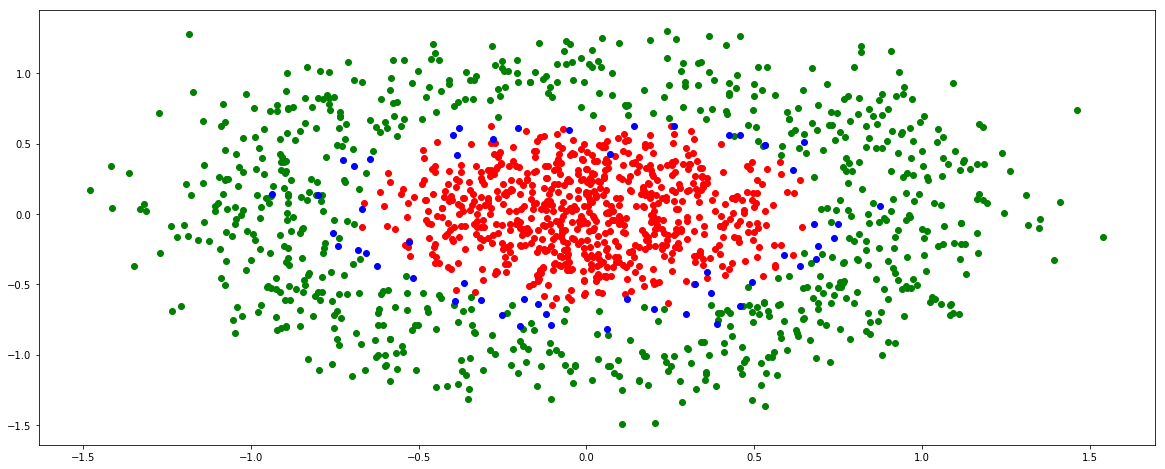

In [97]:
plt.figure(figsize = (20,8))
plt.scatter(x_test1[pair_points==0][:,0], x_test1[pair_points==0][:,1], color = 'g')
plt.scatter(x_test1[pair_points==1][:,0], x_test1[pair_points==1][:,1], color = 'r')
plt.scatter(x_test1[pair_points==-1][:,0], x_test1[pair_points==-1][:,1], color = 'b')

Los puntos rojos son los que el modelo considera dentro de la circunferencia y verde para los que se encuentran fuera. Los puntos de color azul son los puntos que no fueron bien clasificados por el modelo.

Este modelo de SVM con parámetros C = 0.1 y gamma = 1, nos ofrece un SVM casi nativo con un poco gamma, es decir, no es tolerante a puntos dentro de los márgenes y tiende a no sobreajustar. Por lo tanto la frontera de decisión es sensible a los datos de entrenamiento no ajustandose a ellos, si no considerándolos en busca de la generalización.

La razón de porqué el modelo falla con estas muestras va principalmente a que como tiene un C bajo, es muy minucioso con los puntos dentro de los márgenes. Eso hace que varíe mucho la frontera de decisión, ya que con un C más alto puede admitir ciertos errores y generalizar un poco más. Por otra parte, como el error es inducido con una distribución normal, puede que ese error sea lo suficiente para engañar al modelo y tener datos erróneos.

Si hubiesemos tomado el conjunto sin errores el modelo lograría predecirlo completamente, ya que los puntos siguen un patrón específico. El uso de máximo margen implicará que buscará una frontera la cual la mínima distancia al punto más cercano sea la mayor, y como no hay error y son círculos perfectos, la distancia entre los círculos es la misma, por lo que es rápidamente identificable que el modelo convergerá bastante rápido y de forma excelente. Lo anterior parece muy satisfactorio, pero se conoce que en problemas reales los datos no son generados por algo estable.

## h) Kernel

Tras buscar varios modelos que puedan adaptarse a un problema no lineal, es hora de enfocarse como podemos corregir cierto set de datos para que pueda ser lineal y así poder ocupar otros métodos. Una forma es aplicar un Kernel con PCA donde vamos a aumentar la dimensionalidad buscando logral la linealidad de los datos. Para eso, se realizará lo siguiente:

In [0]:
ker = KernelPCA(2,kernel='rbf',gamma=5)
ker.fit(x_train1)
X_ker_train = ker.transform(x_train1)

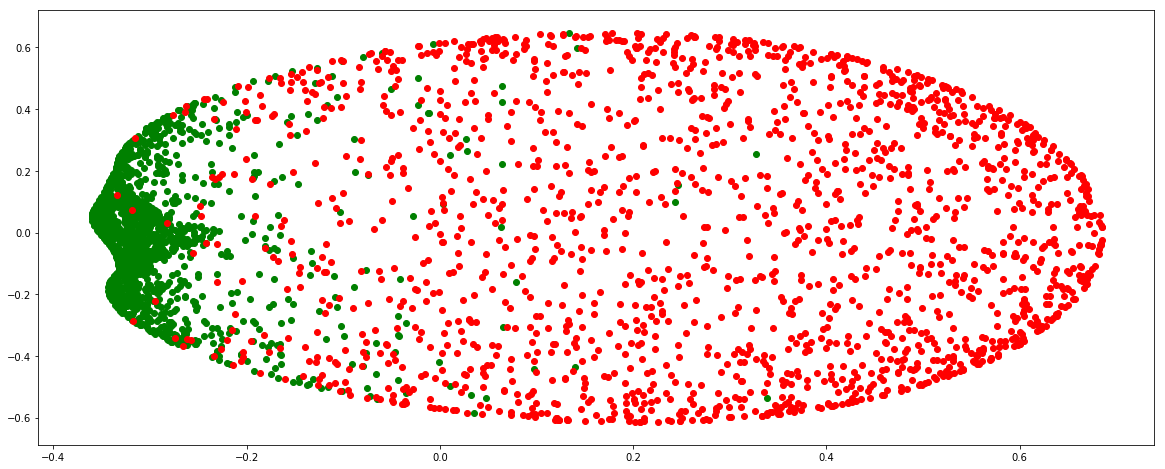

In [109]:
plt.figure(figsize = (20,8))
plt.scatter(X_ker_train[y_train1==0][:,0], X_ker_train[y_train1==0][:,1], color = 'g')
plt.scatter(X_ker_train[y_train1==1][:,0], X_ker_train[y_train1==1][:,1], color = 'r')

Como se puede apreciar, los puntos están logrando transformarse de una forma que pueden ser linealmente separables. Ocuparemos distintos parámetros del algoritmo para analizar que valores nos separará mejor los datos.

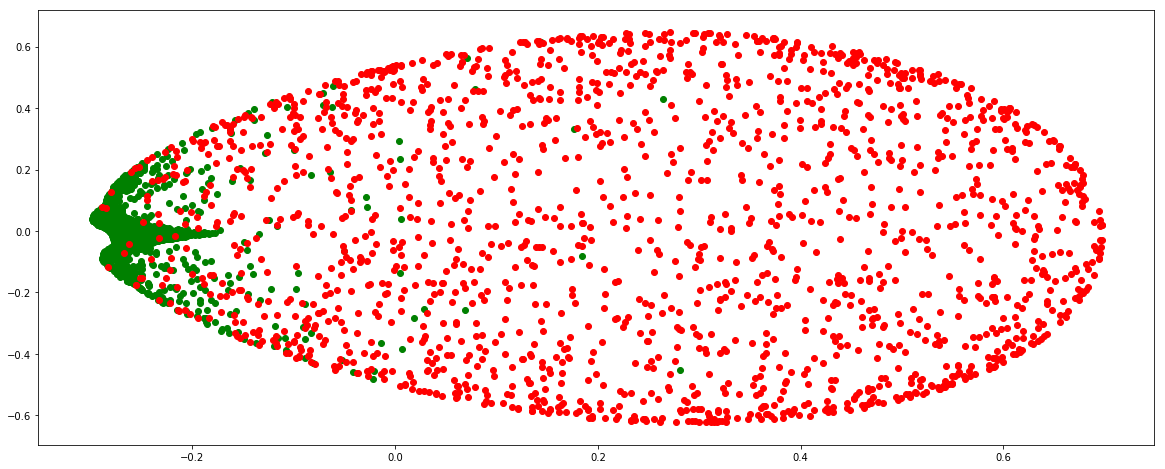

In [118]:
ker = KernelPCA(2,kernel='rbf',gamma=8)
ker.fit(x_train1)
X_ker_train = ker.transform(x_train1)
plt.figure(figsize = (20,8))
plt.scatter(X_ker_train[y_train1==0][:,0], X_ker_train[y_train1==0][:,1], color = 'g')
plt.scatter(X_ker_train[y_train1==1][:,0], X_ker_train[y_train1==1][:,1], color = 'r')

Ahora debemos analizar como un modelo de regresión lineal logrará modelar este problema después de la transformación. Se graficará para observar mejor el desempeño.

In [119]:
log_reg1 = LogisticRegression() 
log_reg1.fit(X_ker_train, y_train1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

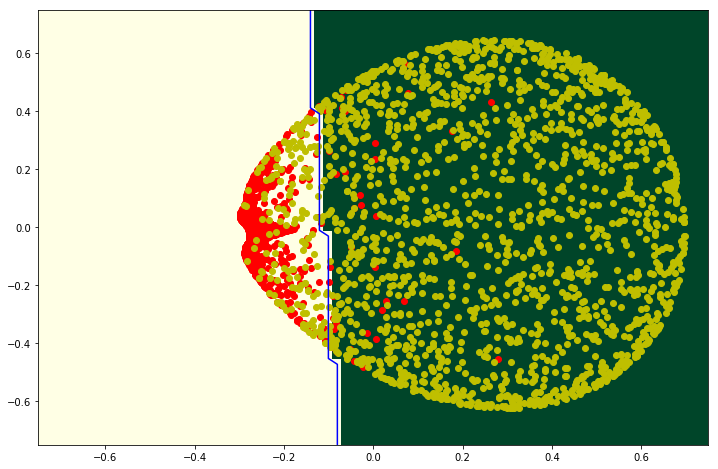

In [127]:
plot_classifier(log_reg1, X_ker_train, y_train1, x_test1, y_test1, [[-0.75,0.75], [-0.75,0.75]], 'train', True)

In [128]:
log_reg1.score(X_ker_train, y_train1)

0.9405714285714286

Podemos apreciar que la aplicación de PCA nos da un buen desempeño con un modelo lineal. Aún así podemos apreciar que no es 100% lineal ya que hay muchos puntos mal clasificados, pero aún así se logra un desempeño bastante bueno, lo que logramos aplicar un modelo lineal a este problema aparentemente posible de realizar con esos modelos. 

#Conclusión

Los problemas no linealmente separables son bastante numerosos y han sido en el pasado un quebradero de cabeza para los modelos que iban apareciendo, incluso en las SVM en los años 90'. Debido a esto se fueron buscando métodos parciales para poder abordar estos problemas aunque los modelos solo lograsen aproximarse linealmente. El uso de PCA nos ofrece un nuevo acercamiento, enfocandonos más en la estructura de nuestro problema (los datos) más que en la técnica que se ocupa para aprender esta estructura.

Con lo anterior, queda expuesto que no solo hay que centrarse en buscar modelos adecuados o los parámetros que den un mejor resultado, si no que la manipulación de los datos nos ayudará demasiado a que diversos modelos puedan aprender eficientemente el problema dado. Por esto que es necesario realizar un exhaustivo análisis del comportamiento y que tan moldeable son los datos de entrenamiento antes de aplicar un modelo específico, ya que dará una mayor comprensión del problema y, también, nuevas luces respecto a soluciones mejores.